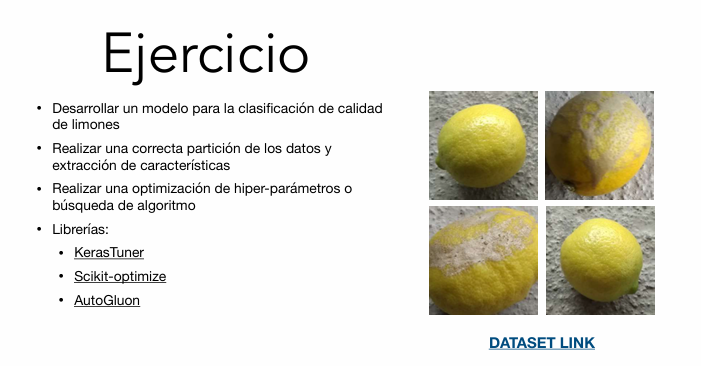

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [4]:
!pip install scikit-optimize # This line installs the 'skopt' library

import os
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from skopt import gp_minimize # Now you should be able to import gp_minimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.3 MB/s eta 0:00:00


<ipython-input-4-31e8c4528392>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
# Directorio donde se encuentran las imágenes originales
original_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/S12'

# Directorio donde se almacenarán las imágenes divididas en conjuntos de entrenamiento, validación y prueba
base_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon'
os.makedirs(base_dir, exist_ok=True)

# Directorios para las categorías de limones
categories = ['good_quality', 'bad_quality']

In [6]:
# Crear directorios para entrenamiento, validación y prueba
for category in categories:
    os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)

# Copiar imágenes a los directorios correspondientes
for category in categories:
    category_dir = os.path.join(original_dir, category)
    file_list = os.listdir(category_dir)

    # Dividir las imágenes en conjuntos de entrenamiento (80%), validación (10%) y prueba (10%)
    train_files, test_files = train_test_split(file_list, test_size=0.2, random_state=42)
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    # Copiar archivos a los directorios correspondientes
    for file_name in train_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'train', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in valid_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'validation', category, file_name)
        shutil.copyfile(src, dst)

    for file_name in test_files:
        src = os.path.join(category_dir, file_name)
        dst = os.path.join(base_dir, 'test', category, file_name)
        shutil.copyfile(src, dst)

# Imprimir la cantidad de imágenes en cada conjunto
for split in ['train', 'validation', 'test']:
    for category in categories:
        category_dir = os.path.join(base_dir, split, category)
        print(f"{split} {category} images: {len(os.listdir(category_dir))}")




train good_quality images: 900
train bad_quality images: 760
validation good_quality images: 112
validation bad_quality images: 95
test good_quality images: 113
test bad_quality images: 96


In [7]:
import os
import shutil
from PIL import Image

def load_image(file_path):
    try:
        img = Image.open(file_path)
        img.load()
        return img
    except:
        return None

def remove_invalid_images(directory):
    invalid_images = []
    # Recorre todas las imágenes en el directorio
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Intenta cargar la imagen
            img = load_image(file_path)
            # Si la imagen no se puede abrir o no existe, la agregamos a la lista de imágenes inválidas
            if img is None:
                invalid_images.append(file_path)

    # Elimina las imágenes inválidas
    for file_path in invalid_images:
        os.remove(file_path)
        print(f"Imagen eliminada: {file_path}")

In [8]:
# Directorio donde se encuentran las imágenes
train_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/train'
test_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/test'
validation_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/validation'

# Elimina las imágenes inválidas del directorio de entrenamiento
remove_invalid_images(train_dir)
remove_invalid_images(test_dir)
remove_invalid_images(validation_dir)


In [9]:
# Directorios de los conjuntos de datos
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Configuración del generador de imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores de imágenes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 1660 images belonging to 2 classes.
Found 207 images belonging to 2 classes.
Found 209 images belonging to 2 classes.


In [10]:
import os

# Directorio donde se encuentran las divisiones del conjunto de datos
train_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/train'
valid_dir = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/validation'
test_dir ='/content/drive/MyDrive/Vision/Ejercicios_clase/limon/test'


# Ruta de la imagen eliminada
deleted_image_path = '/content/drive/MyDrive/Vision/Ejercicios_clase/limon/train/bad_quality/bad_quality_119.jpg'

# Función para verificar la presencia de la imagen en una carpeta
def check_image_presence(directory, image_path):
    for root, dirs, files in os.walk(directory):
        if image_path in files:
            return True
    return False

# Verificar la presencia de la imagen eliminada en cada división del conjunto de datos
train_image_present = check_image_presence(train_dir, deleted_image_path)
valid_image_present = check_image_presence(valid_dir, deleted_image_path)
test_image_present = check_image_presence(test_dir, deleted_image_path)

# Imprimir los resultados
print(f"La imagen eliminada está presente en el conjunto de entrenamiento: {train_image_present}")
print(f"La imagen eliminada está presente en el conjunto de validación: {valid_image_present}")
print(f"La imagen eliminada está presente en el conjunto de prueba: {test_image_present}")

La imagen eliminada está presente en el conjunto de entrenamiento: False
La imagen eliminada está presente en el conjunto de validación: False
La imagen eliminada está presente en el conjunto de prueba: False


In [17]:
# Definir la estructura del modelo
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_filter', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv2_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv3_filter', min_value=32, max_value=64, step=16), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras_tuner import RandomSearch

# Definir el tuner para la optimización de hiperparámetros
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner',
    project_name='lemon_quality')

# Ejecutar la búsqueda de hiperparámetros
tuner.search(train_generator,
             validation_data=valid_generator,
             epochs=5,
             verbose=1)

# Obtener el mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]

# Imprimir el resumen del mejor modelo
best_model.summary()

Trial 5 Complete [00h 06m 01s]
val_accuracy: 0.5410627722740173

Best val_accuracy So Far: 0.95652174949646
Total elapsed time: 00h 42m 18s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 112)       │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 112)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          64,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         591,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 696,577 (2.66 MB)

 Trainable params: 696,577 (2.66 MB)

 Non-trainable params: 0 (0.00 B)